# Introduccion a los circuitos variacionales

In [2]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
mpl.rcParams['figure.dpi'] = 300

## 1) Introduccion
Esta seccion contiene una introduccion breve del tema de algoritmos variacionales y a manera de repaso del material cubierto en clase.

### Algoritmos cuanticos variacionales
En el sentido mas general, un circuito cuantico variacional depende de un conjunto de parametros $\theta$. En la mayoria de los casos, un circuito variacional utiliza un dispositivo cuantico para obtener una solucion optimizada para el conjunto de parametros $\theta$ y los utiliza para evaluar una funcion de costo $C(\theta)$ basada en dichos resultados. Un optimizador clasico se utiliza despues para actualizar los parametros del circuito con el fin de minimizar o maximizar el valor de la funcion $C$. Estos pasos se repiten en un loop cuantico-clasico hasta que se encuentran los parametros optimos $\theta^{*}$.<br>

Los circuitos variacionales son importantes porque prometen ser uno de los metodos capaces de demostrar la supremacia cuantica en dispositivos cuanticos actuales. Las ventajas de utilizar los circuitos variacionales son las siguientes:

- No require la ejecucion de circuitos cuanticos de extensa longitud.
- Los errores sistematicos son mitigados mediante el uso de un proceso de optimizacion clasico.

Algunos de los algoritmos que utilizan el principio variacional son los siguientes:

- [Variational Quantum Eigensolvers](https://qiskit.org/textbook/ch-applications/vqe-molecules.html): VQEs buscan aproximar el estado de minima energia de un sistema cuantico descrito por el Hamiltoniano $H$.

- [QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html): Algoritmo que busca obtener una solucion aproximada a los problemas de optimizacion combinatoria. El QAOA puede ser visto como un caso especial del VQE, en el que la funcion de costo que se busca minimizar/maximizar se codifica en el Hamiltoniano del problema.

- Clasificadores Variacionales: Consiste en un circuito cuantico que es entrenado en un conjunto de datos en particular y tiene la meta de clasificar datos que nunca ha visto antes.

- [Variational Quantum Linear Solvers](https://qiskit.org/textbook/ch-paper-implementations/vqls.html): Los VQLS buscan resolver sistemas de ecuaciones lineales utilizando las ideas fundamentales detras de los VQEs.

### El metodo variacional

Empezamos considerando un operador Hamiltoniano $H$ que describe un sistema cuantico con estado de minima energia $\vert \psi^* \rangle$ con energia $E_{0}$. El metodo variacional es un metodo que nos permite aproximar $\vert \psi^* \rangle$ y $E_0$. En la ejecucion, se utiliza un estado parameterizado de prueba $\vert \psi(\theta) \rangle$, donde $\theta$ es un conjunto de parametros o vector de parametros que nos permiten aproximar nuestra funcion.<br>

La energia de un sistema en el estado $\vert \psi \rangle$ esta dada por su valor esperado con respecto a $H$:

$$
E(\vert \psi \rangle)= \langle \psi \vert H \vert \psi \rangle
$$
y por lo tanto, 
$$
E_0 = \langle \psi^* \vert H \vert \psi^* \rangle \leq \langle \psi(\theta) \vert H \vert \psi(\theta) \rangle,
$$
para cualquier parametro $\theta$. Entonces, si minimizamos el valor esperado del estado de prueba $\psi(\theta)$, es decir, encontrando los parametros $\theta$ para los cuales el valor esperado $\langle \psi(\theta) \vert H \vert \psi(\theta) \rangle$ adquiere el minimo valor posible, obtenemos una aproximacion del estado de menor energia. Naturalmente, la seleccion de estado de prueba $\psi(\theta)$ tiene un rol vital en los resultados de la implementacion de dicho algoritmo.

## Circuitos Cuanticos PArameterizados (Parameterized Quantum Circuits)
En esta seccion, vamos a aprender como construir circuitos parameterizados y a asignar valores al circuito dentro de Qiskit.

### Construyendo un circuito parameterizado
Crear un circuito con parametros en Qiskit no es muy diferente de crear un circuito cuantico estandar. Simplemente inicializamos los parametros utilizando la clase de Qiskit ```Parameter```. En el siguiente ejemplo, vamos a utilizar esta clase para asignarle los parametros a las compuertas de rotacion.

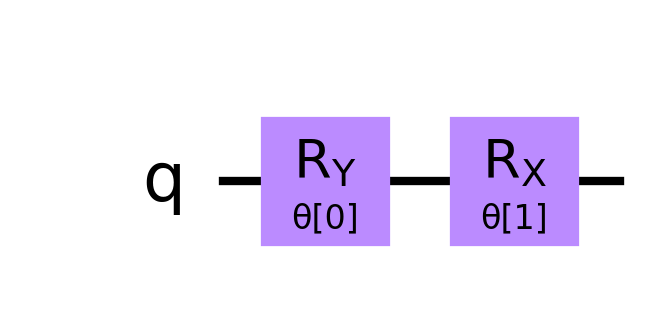

In [4]:
from qiskit.circuit import Parameter, ParameterVector
#Los parametros son inicializados con un nombre
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
circuit = QuantumCircuit(1)
# Despues podemos pasar los parametros inicializados cono argumento a las compuertas Rx y Ry
circuit.ry(theta = parameter_0, qubit = 0)
circuit.rx(theta = parameter_1, qubit = 0)
circuit.draw('mpl')

Los mismos parametros pueden ser utilizados varias veces dentro del mismo circuito. En el siguiente ejemplo, utilizamos el mismo circuito, pero con el mismo parametro para las cos compuertas Rx y Ry

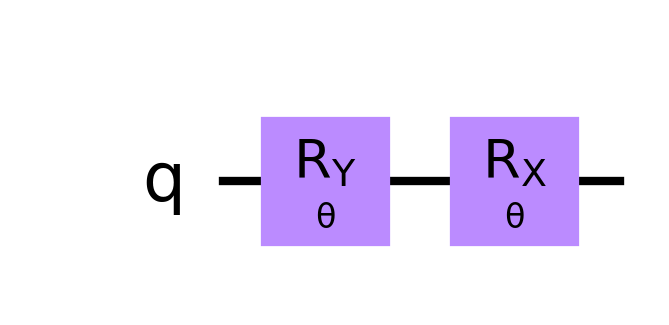

In [5]:
parameter = Parameter('θ')
circuit = QuantumCircuit(1)
circuit.ry(theta = parameter, qubit = 0)
circuit.rx(theta = parameter, qubit = 0)
circuit.draw('mpl')

Por conveniencia, tambien existe una clase denominada ```ParameterVector``` en Qiskit que permite la creacion de multiples parametros al mismo tiempo. En el siguiente ejemplo, construimos el circuito denominado *RealAmplitudes*, que consiste en capas alternas de compuertas $R_{Y}$ y compuertas $CX$. La *forma variacional* o *ansatz* [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) se utiliza en tareas de clasificacion en quantum machine learning y se puede accesar en Qiskit desde la [circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html).

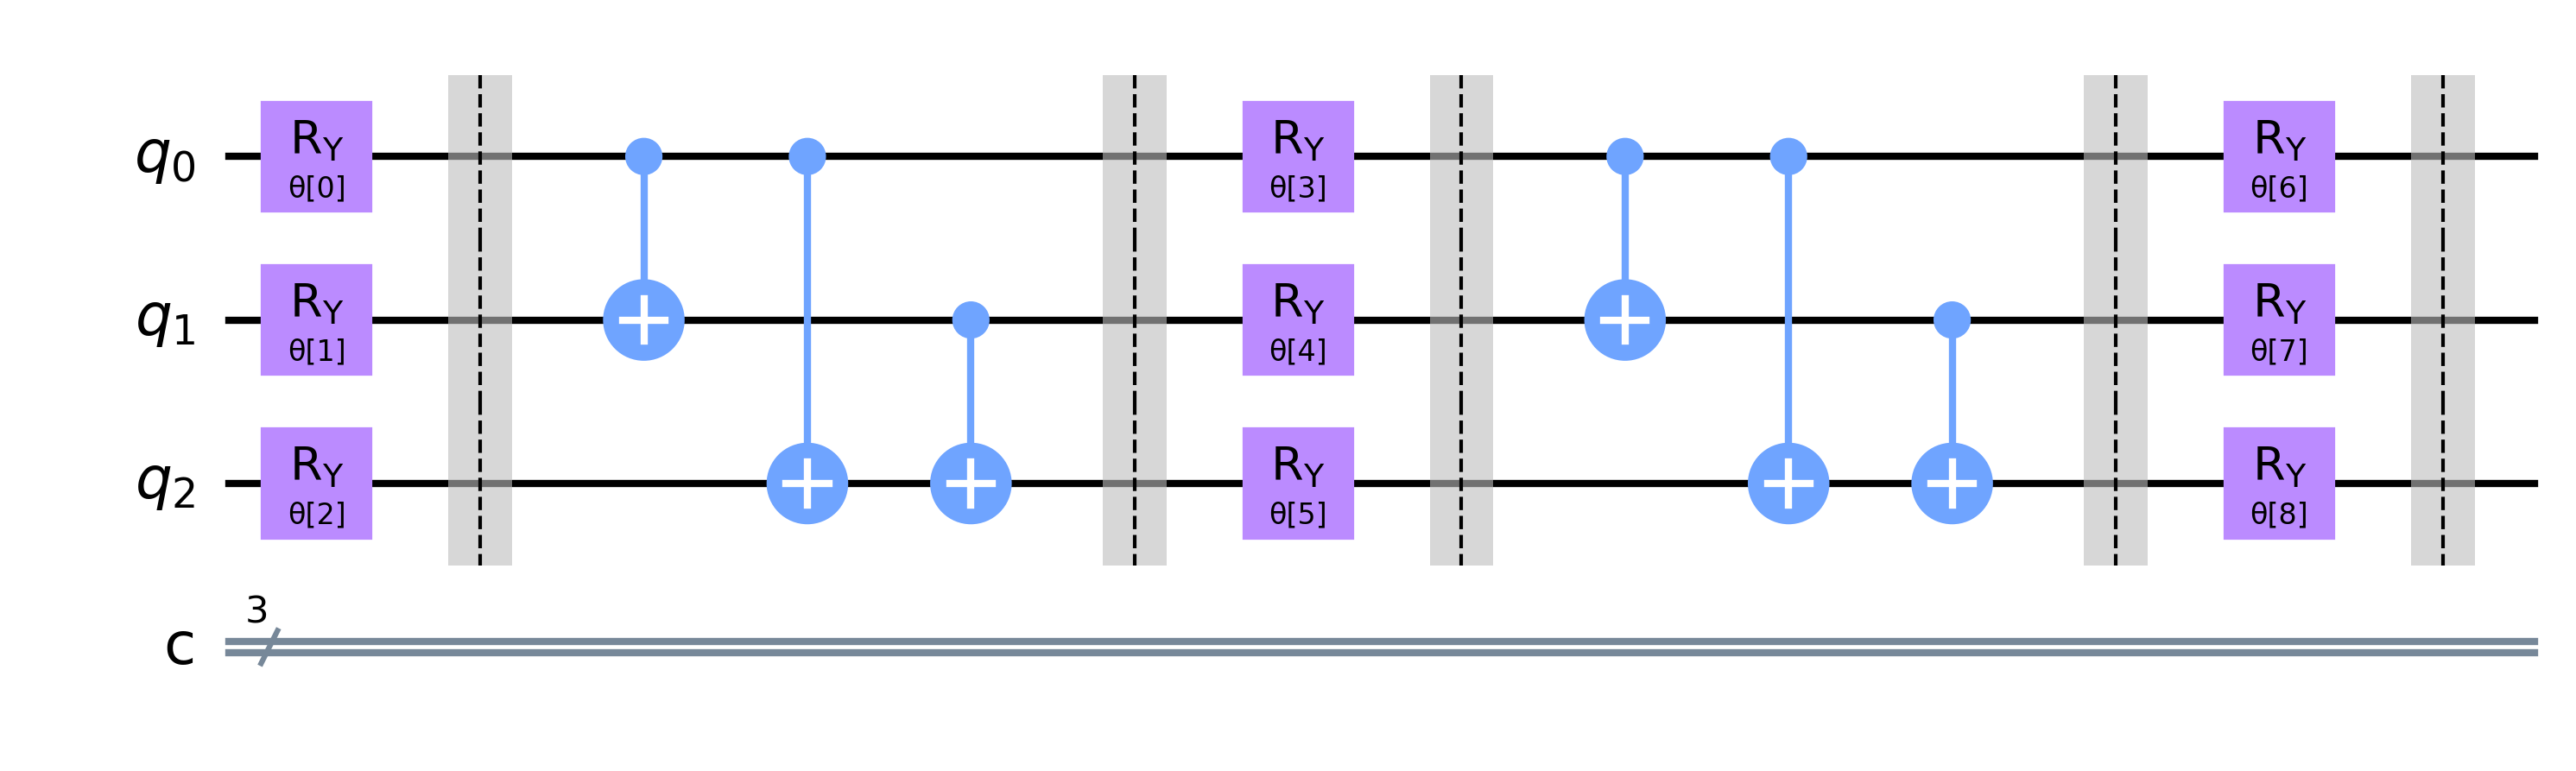

In [7]:
#Definimos el numero de capas(layers) y cubits
n=3
num_layers = 2

#ParameterVectors se inicializa con un nombre en forma de string y con un parametro que indica el tamaño del vector
parameters = ParameterVector('θ', n*(num_layers+1))


circuit = QuantumCircuit(n, n)
for layer in range(num_layers):
    for i in range(n):
        circuit.ry(parameters[n*layer+i], i)
    circuit.barrier()

    for i in range(n):
        for j in range(i):
                circuit.cx(j,i)
    circuit.barrier()

for i in range(n):
    circuit.ry(parameters[n*num_layers+i], i)
circuit.barrier()

circuit.draw('mpl')

por ultimo, podemos inspeccionar los parametros que son parte del circuito:

In [8]:
print(circuit.parameters)

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8])])


### Asignando valores a los parametros
Un circuito parameterizado no puede ser ejecutado hasta que se le ha asignado valores a los parametros definidos. Para hacerlo, podemos utilizar el metodo `QuantumCircuit` 
```
assign_parameters(parameters, inplace = False)
bind_parameters(values)
```
`bind_parameters` asigna valores numericos a los parametros del circuito. Con `assign_parameters`, podemos asignar valores numericos o sustituir los parametros por otras expresiones.

{ParameterVectorElement(θ[0]): 0.10954121544677475, ParameterVectorElement(θ[1]): 0.15896670271118896, ParameterVectorElement(θ[2]): 0.08512521428873399, ParameterVectorElement(θ[3]): 0.6790843836103311, ParameterVectorElement(θ[4]): 0.09658698907785013, ParameterVectorElement(θ[5]): 0.04702322850332763, ParameterVectorElement(θ[6]): 0.6363814506392171, ParameterVectorElement(θ[7]): 0.3651704966366969, ParameterVectorElement(θ[8]): 0.01184871449503877}


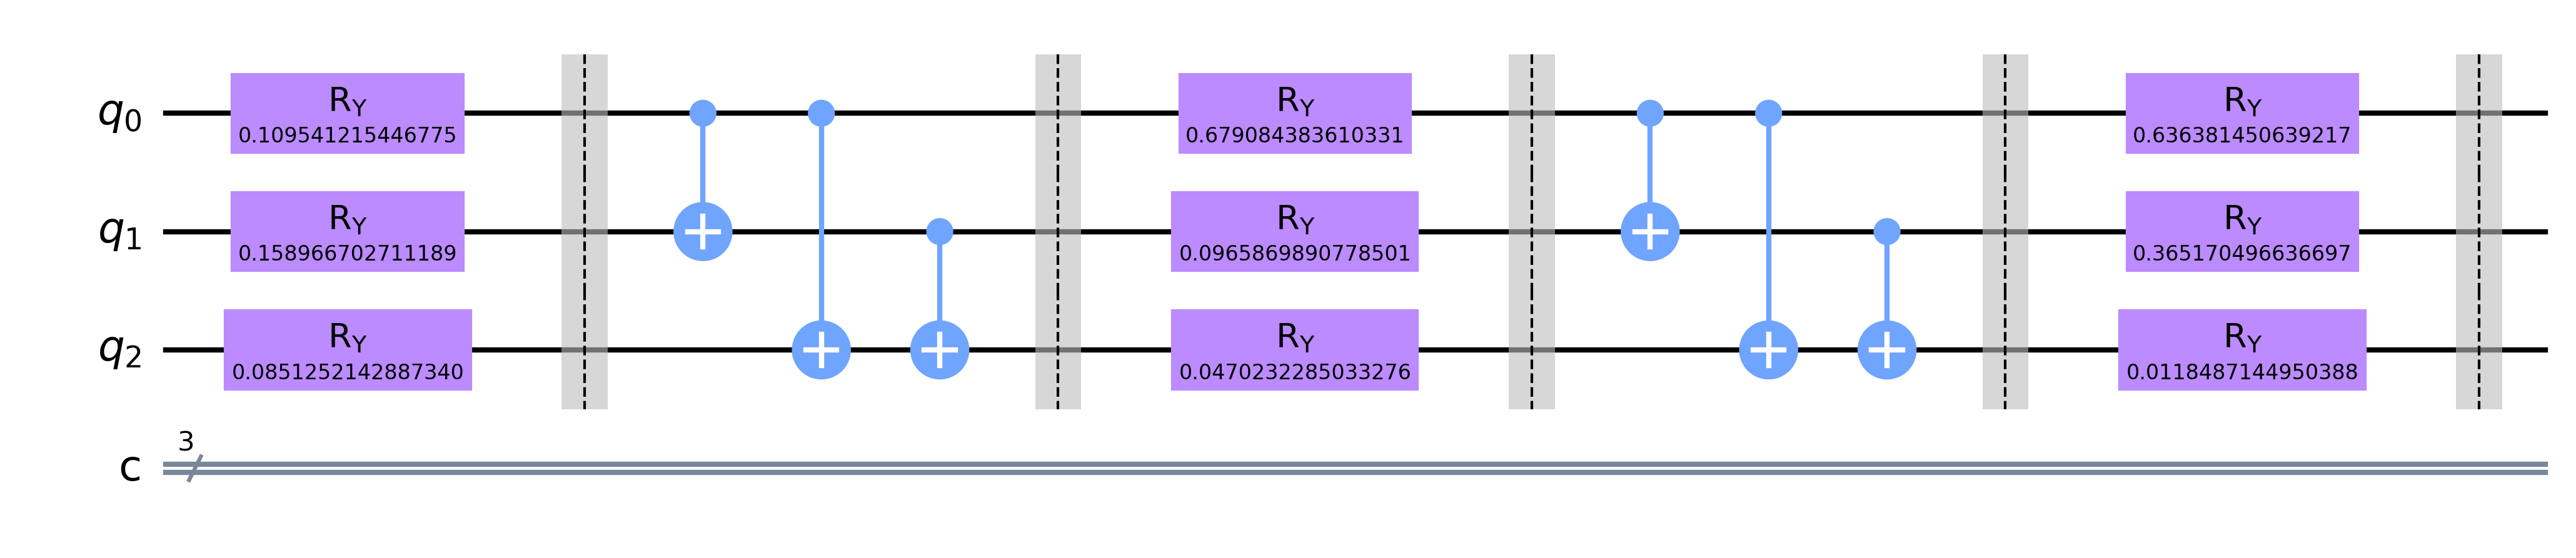

In [9]:
#Creamos un diccionario con valores aleatorios
param_dict = {parameter: np.random.random() for parameter in parameters}
print(param_dict)
#Asignamos parametros usando el metodo assign_parameters
bound_circuit = circuit.assign_parameters(parameters = param_dict)
bound_circuit.draw('mpl')

O podemos sustituir algunos de los parametros por una expresion o valor diferente:

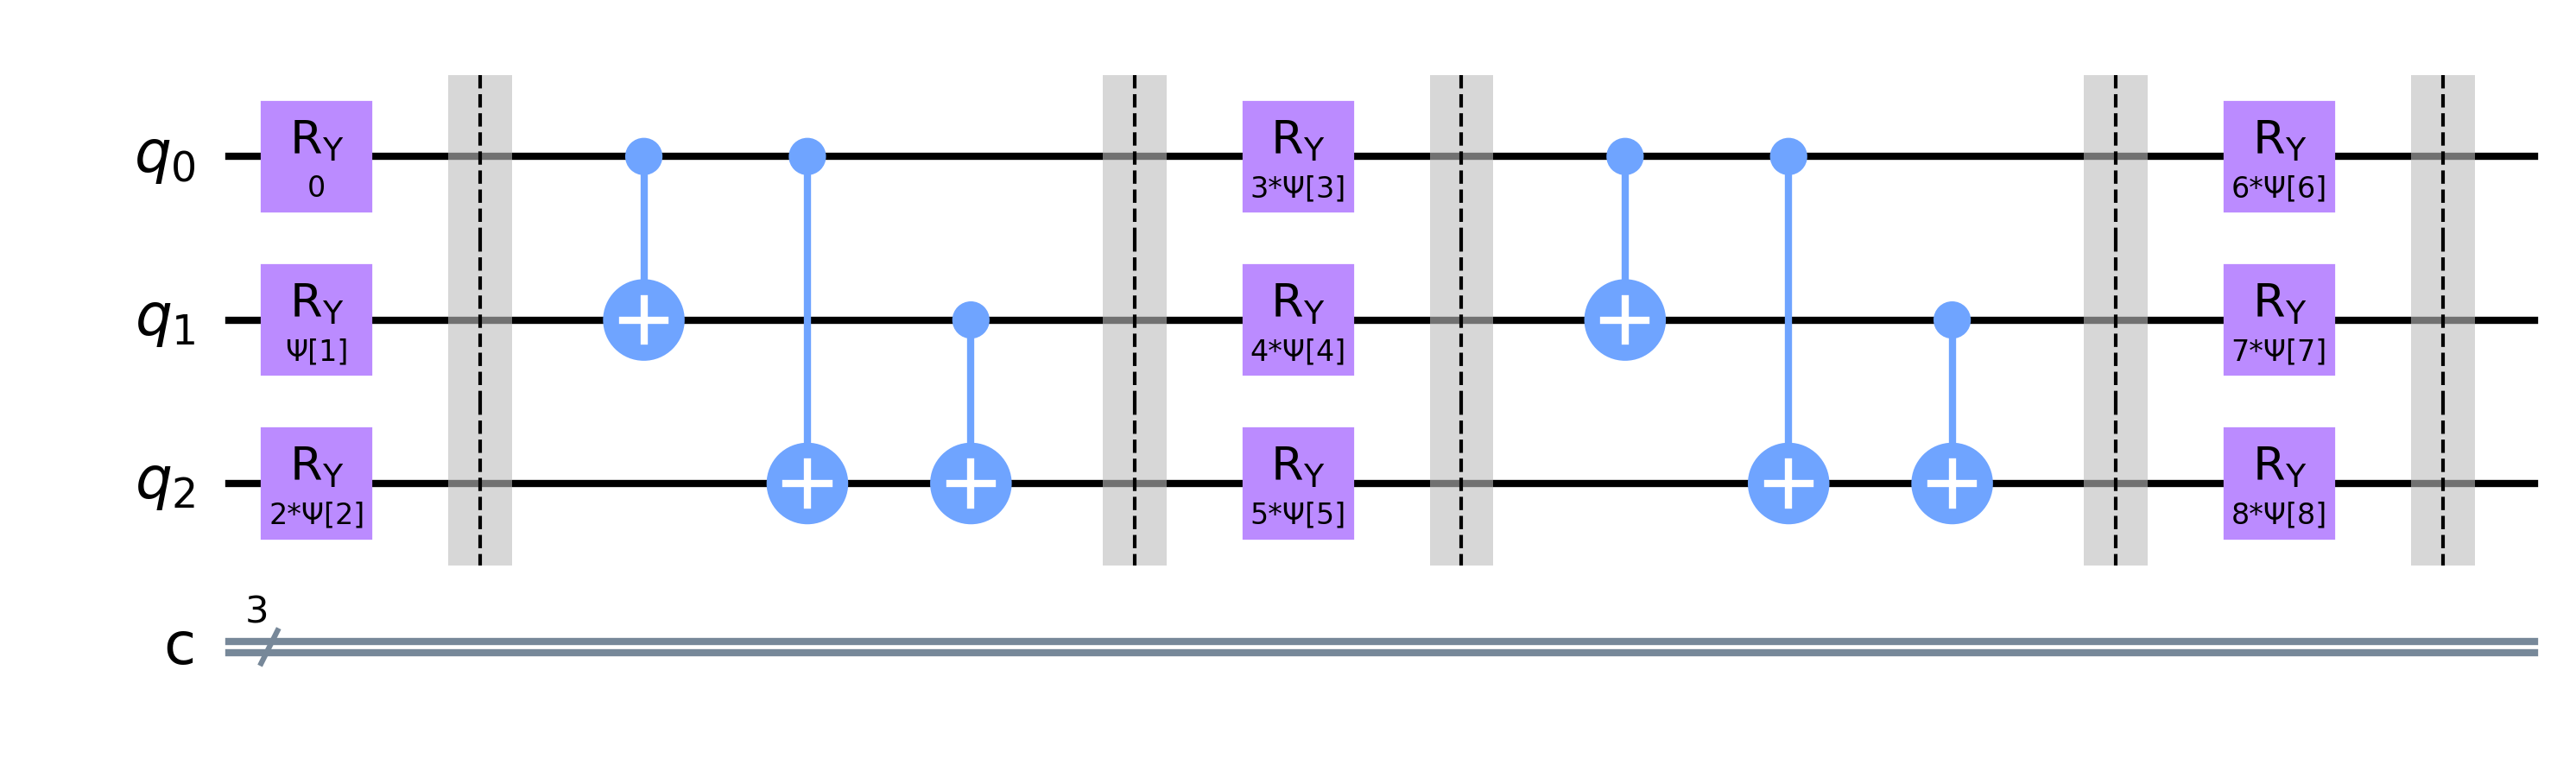

In [10]:
new_parameters = ParameterVector('Ψ',9)
new_circuit = circuit.assign_parameters(parameters = [k*new_parameters[k] for k in range(9)])
new_circuit.draw('mpl')

y ahora si podemos ejecutar el circuito en un dispositivo cuantico o simulador.

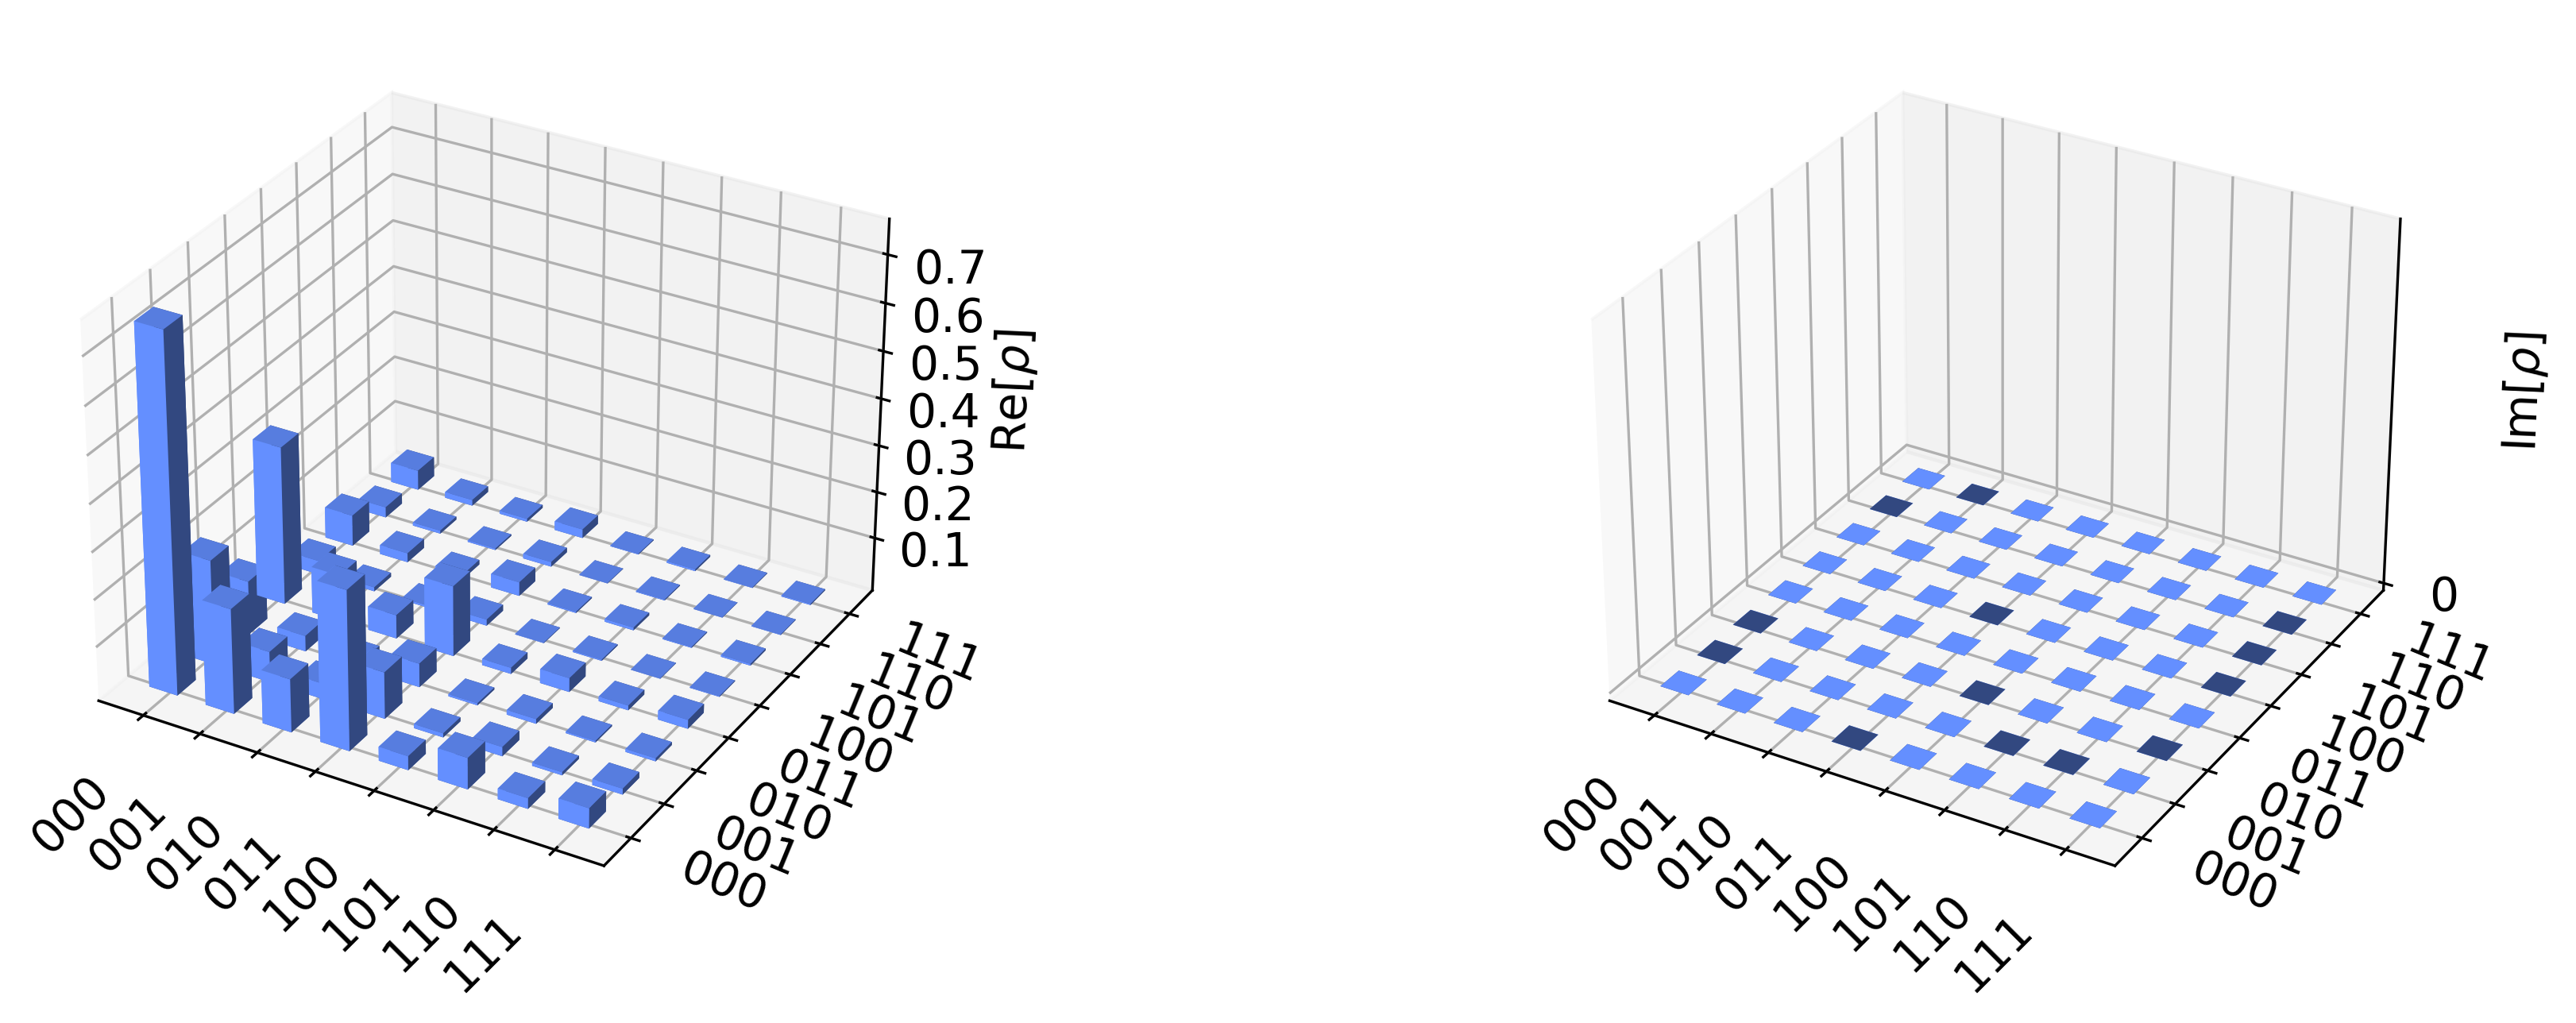

In [11]:
simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(bound_circuit).result()
statevector = result.get_statevector(bound_circuit)
plot_state_city(statevector)